In [1]:
#-- Import Modules
import os
import imp
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import keras
from keras import backend as K
from keras.preprocessing import image
from tensorflow.python.client import device_lib
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from PIL import Image
from skimage import feature
from skimage.morphology import skeletonize
from skimage.segmentation import chan_vese
from skimage.restoration import unwrap_phase
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import binary_dilation

Using TensorFlow backend.
/Users/yaramohajerani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yaramohajerani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yaramohajerani/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yaramohaje

In [4]:
#-- Set up configurations / parameters
retrain = False # retrain previously existing model
ndown = 4 # number of 'down' steps
ninit = 32 #number of channels to start with
dropout_frac = 0.2 # dropout fraction
n_batch = 10
n_epochs = 60
dilation_kernel = 4 #-- kernel size for increasing thickness of training labels
dilate = False
augment = False
suffix = ''
if dilate:
  suffix += '_dilated'
if augment:
  suffix += '_augmented'
aug_num = 1

In [2]:
#-- Directory setup
colabdir = os.path.expanduser('~/Google Drive File Stream/My Drive/Colab Notebooks/')
ddir = os.path.expanduser('~/Google Drive File Stream/Shared drives/GROUNDING_LINE_TEAM_DRIVE/ML_Yara/')
train_dir = os.path.join(ddir,'Slant_Imagery','training_data')
test_dir = os.path.join(ddir,'Slant_Imagery','testing_data')

#-- Get list of images
fileList = os.listdir(train_dir)
train_list = [f for f in fileList if f.endswith('_coco.tif')]
fileList = os.listdir(test_dir)
test_list = [f for f in fileList if f.endswith('_coco.tif')]

In [10]:
raster = rasterio.open(os.path.join(train_dir,train_list[15]))
im = raster.read(1)
channels = raster.count

#-- Read training images
train_imgs = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],channels))
train_lbls = np.ones((len(train_list)*aug_num,im.shape[0],im.shape[1],1))
for i,f in enumerate(train_list):
    #-- read image
    raster = rasterio.open(os.path.join(train_dir,f))
    for c in range(channels):
        train_imgs[i,:,:,c] = raster.read(c+1)
        # train_imgs[i+1,:,:,c] = np.fliplr(raster.read(c+1))
        # train_imgs[i+2,:,:,c] = np.flipud(raster.read(c+1))
        # train_imgs[i+3,:,:,c] = np.fliplr(np.flipud(raster.read(c+1)))
    #-- read label
    raster = rasterio.open(os.path.join(train_dir,f.replace('coco.tif','mask.tif')))
    if dilate:
      train_lbls[i,:,:,0] = binary_dilation(raster.read(1))
    else:
      train_lbls[i,:,:,0] = raster.read(1)
    # train_lbls[i+1,:,:,0] = binary_dilation(np.fliplr(raster.read(1)))
    # train_lbls[i+2,:,:,0] = binary_dilation(np.flipud(raster.read(1)))
    # train_lbls[i+3,:,:,0] = binary_dilation(np.fliplr(np.flipud(raster.read(1))))
    #i += 4

#-- Read test data
test_imgs = np.ones((len(test_list),im.shape[0],im.shape[1],channels))
test_lbls = np.ones((len(test_list),im.shape[0],im.shape[1],1))
for i,f in enumerate(test_list):
    #-- read image
    raster = rasterio.open(os.path.join(test_dir,f))
    for c in range(channels):
        test_imgs[i,:,:,c] = raster.read(c+1) #.transpose()
    #-- read label
    raster = rasterio.open(os.path.join(test_dir,f.replace('coco.tif','mask.tif')))
    test_lbls[i,:,:,0] = raster.read(1)
    # test_lbls[i,:,:,0] = cv2.dilate(raster.read(1),kernel,iterations = 1) #.transpose()

In [8]:
model = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(512,512,3), pooling='avg')

In [14]:
features.shape

(34, 2048)

In [17]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 20s 0us/step


In [18]:
features = model.predict(test_imgs)

In [19]:
features.shape

(34, 16, 16, 512)

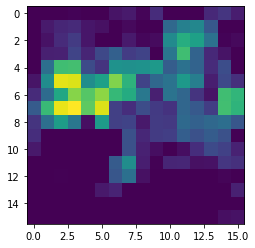

In [28]:
plt.imshow(features[0,:,:,0])
plt.show()